# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

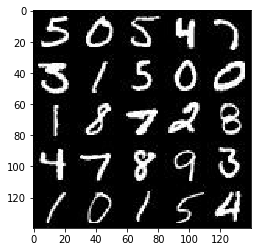

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot as pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

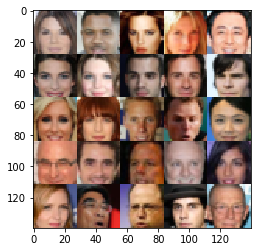

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="intput_images")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #print(images)
    alpha = .2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #The idea to use the xavier initializer came from a forum entry
        first_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        first_layer = tf.maximum(first_layer * alpha, first_layer)
        
        second_layer = tf.layers.conv2d(first_layer, 128, 5, strides=2, padding='same')
        second_layer = tf.layers.batch_normalization(second_layer, training=True)
        second_layer = tf.maximum(second_layer * alpha, second_layer)
        
        third_layer = tf.layers.conv2d(second_layer, 256, 5, strides=2, padding='same')
        third_layer = tf.layers.batch_normalization(third_layer, training=True)
        third_layer = tf.maximum(third_layer * alpha, third_layer)
        
        flattened = tf.reshape(third_layer, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)
                                                
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = .2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        first_layer = tf.layers.dense(z, 4*4*512)
        first_layer = tf.reshape(first_layer, (-1, 2, 2, 512))
        first_layer = tf.layers.batch_normalization(first_layer, training=is_train)
        #print(first_layer.shape)
        
        #The idea to use the xavier initializer came from a forum entry
        second_layer = tf.layers.conv2d_transpose(first_layer, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        second_layer = tf.layers.batch_normalization(second_layer, training=is_train)
        second_layer = tf.maximum(second_layer * alpha, second_layer)
        #print(second_layer.shape)
        
        third_layer = tf.layers.conv2d_transpose(second_layer, 128, 5, strides=3, padding='valid')
        third_layer = tf.layers.batch_normalization(third_layer, training=is_train)
        third_layer = tf.maximum(third_layer * alpha, third_layer)
        #print(third_layer.shape)
        
        logits = tf.layers.conv2d_transpose(third_layer, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    #print(input_real)
    #print(g_model)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print('epoch_count={}'.format(epoch_count))
    #print('batch_size={}'.format(batch_size))
    #print('z_dim={}'.format(z_dim))
    #print('learning_rate={}'.format(learning_rate))
    #print('beta1={}'.format(beta1))
    #print(get_batches)
    #print('data_shape={}'.format(data_shape))
    #print('data_image_mode={}'.format(data_image_mode))
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                
                if steps % 10 == 0:
                    # Get the losses and print them out after 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 8, input_z, data_shape[3], data_image_mode)

    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2692... Generator Loss: 24.3207
Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 4.6641
Epoch 1/2... Discriminator Loss: 2.6595... Generator Loss: 0.2239
Epoch 1/2... Discriminator Loss: 2.1001... Generator Loss: 0.1732
Epoch 1/2... Discriminator Loss: 3.3237... Generator Loss: 0.1119
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 0.2860
Epoch 1/2... Discriminator Loss: 2.3462... Generator Loss: 0.1558
Epoch 1/2... Discriminator Loss: 1.7354... Generator Loss: 0.3330
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.2679
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.4780


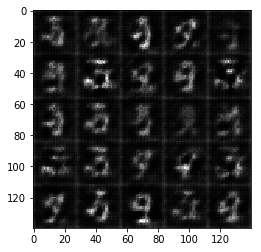

Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.5036
Epoch 1/2... Discriminator Loss: 1.6058... Generator Loss: 0.3021
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.3431
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.3217
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.3417


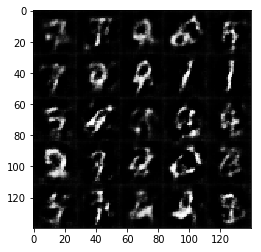

Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.3908
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.4297
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.4595
Epoch 1/2... Discriminator Loss: 1.6464... Generator Loss: 0.2799
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.4813


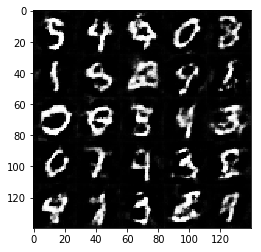

Epoch 1/2... Discriminator Loss: 2.3267... Generator Loss: 0.1271
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 1.0062
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 1.4836
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.0693
Epoch 1/2... Discriminator Loss: 1.6285... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 1.7104
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.6432


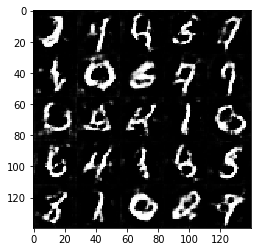

Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.9876... Generator Loss: 0.1814
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 1.9487... Generator Loss: 0.1918
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.3998
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.4716
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.5896


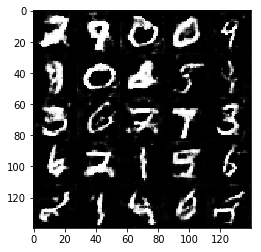

Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 2.9547... Generator Loss: 0.0677
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.2804
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 1.2120
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 1.4350
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.2913
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 1.1051
Epoch 1/2... Discriminator Loss: 1.8234... Generator Loss: 2.0979


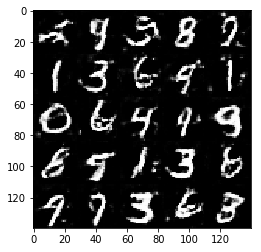

Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.3636
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 1.4764
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 1.4163
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.6434


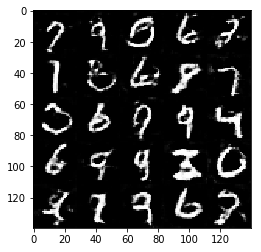

Epoch 1/2... Discriminator Loss: 1.8880... Generator Loss: 1.8182
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 1.2111
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 0.3113
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.3799
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.3727
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.3316


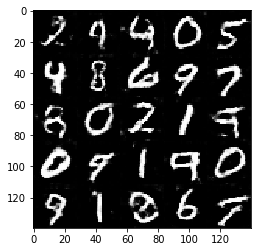

Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 3.5626... Generator Loss: 3.9391
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 1.2199
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.9381
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 0.2634


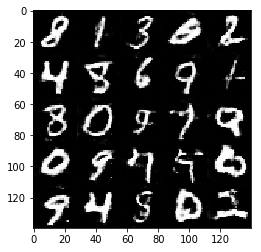

Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 0.2369
Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.3541
Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.3501
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.4378


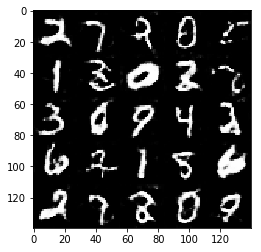

Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.3933
Epoch 1/2... Discriminator Loss: 1.8164... Generator Loss: 0.2164
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.3215
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 2.6876... Generator Loss: 2.9110
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.5470


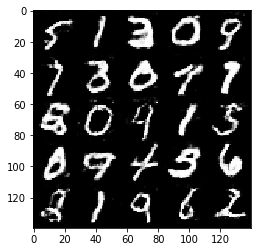

Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.4212
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.4023
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 1.2812
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 0.6120


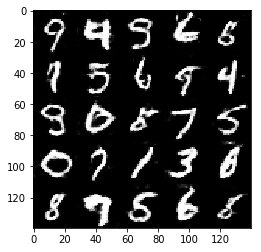

Epoch 2/2... Discriminator Loss: 1.6017... Generator Loss: 0.2842
Epoch 2/2... Discriminator Loss: 1.6677... Generator Loss: 0.2609
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.4181
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 3.4971... Generator Loss: 3.7744
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.6206
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.8118
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 1.3372
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 1.4238


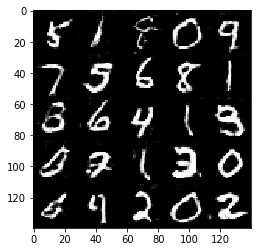

Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 1.6419... Generator Loss: 1.7719
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 0.9562
Epoch 2/2... Discriminator Loss: 1.4579... Generator Loss: 2.0028
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 1.8341... Generator Loss: 0.2195
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 1.8119... Generator Loss: 0.2341


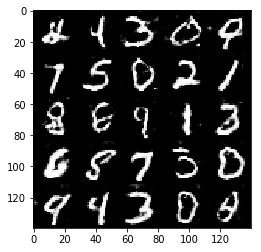

Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 2.0548... Generator Loss: 2.0283
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.5929... Generator Loss: 0.3442
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.7684... Generator Loss: 1.7503
Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 1.0979


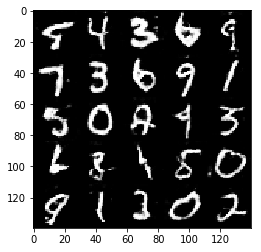

Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 1.6052
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.9903
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 1.6477
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.0893
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 1.4405
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 0.7128


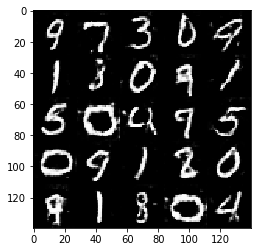

Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.4586
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.4890
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 1.5000
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 1.5958
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 1.4387
Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.5334


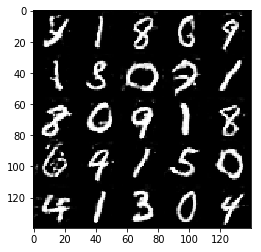

Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.5821... Generator Loss: 0.2928
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 2.1019... Generator Loss: 0.1848
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 0.8242... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 1.8568
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 1.5633
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.3833


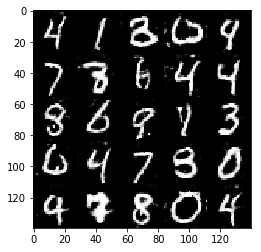

Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.4618
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.4163
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 2.2998... Generator Loss: 3.0958
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 1.3588
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 1.5973
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 1.7472... Generator Loss: 1.8718


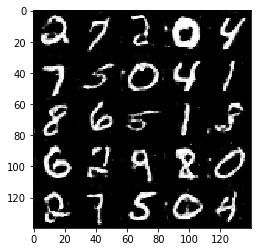

Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 1.1808
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.2705
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 1.7696
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 1.2120
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.0819
Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 1.5635... Generator Loss: 2.1288
Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 1.5055
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.3307


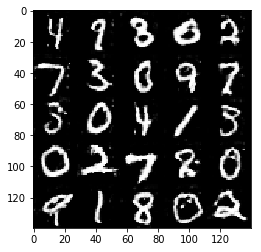

Epoch 2/2... Discriminator Loss: 2.0719... Generator Loss: 0.1645
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 2.0345... Generator Loss: 2.5885
Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.4117
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.3559
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.3529
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.3226
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.4638


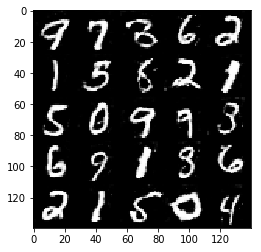

Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.4212
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 0.5692
Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.3378
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.3595


Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.3358
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.6373
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 1.5609... Generator Loss: 0.3347
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 1.8262
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.2028


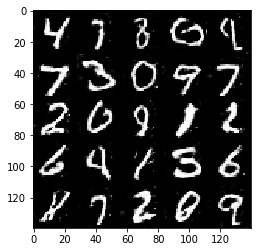

Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 1.7599
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.6162... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 1.4102
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.5836
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 1.2570
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 2.1767
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 0.8051


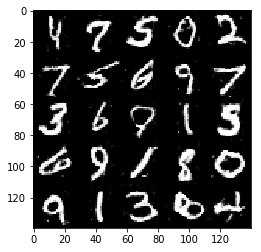

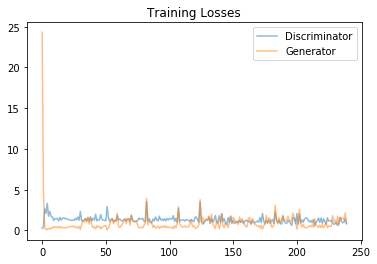

In [19]:
batch_size = 50
z_dim = 50
learning_rate = .001
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 6.2499
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 2.9637
Epoch 1/1... Discriminator Loss: 4.5921... Generator Loss: 0.0689
Epoch 1/1... Discriminator Loss: 2.0755... Generator Loss: 4.8704
Epoch 1/1... Discriminator Loss: 5.1667... Generator Loss: 5.5334
Epoch 1/1... Discriminator Loss: 1.8522... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.8104
Epoch 1/1... Discriminator Loss: 2.3316... Generator Loss: 0.2151
Epoch 1/1... Discriminator Loss: 2.9290... Generator Loss: 3.8315
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 0.8372


Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 2.7552
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 2.3516
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 2.4910... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 2.3976... Generator Loss: 0.1827


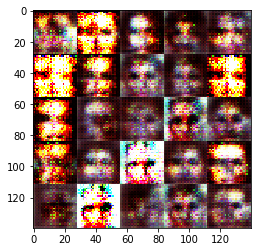

Epoch 1/1... Discriminator Loss: 1.8026... Generator Loss: 0.2401
Epoch 1/1... Discriminator Loss: 0.3027... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 2.0247... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 3.7557
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 3.7435
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 3.4794
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 3.4582
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 1.4592


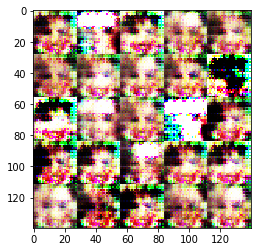

Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.8236
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7436


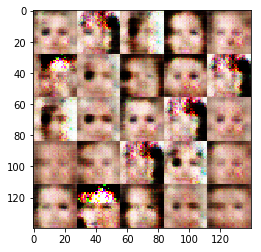

Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 4.4382... Generator Loss: 4.7413
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.6738


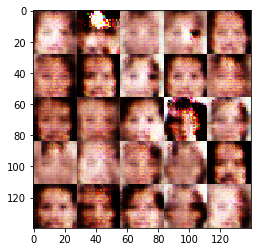

Epoch 1/1... Discriminator Loss: 3.9654... Generator Loss: 4.5476
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 1.9373
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 2.4516
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6243


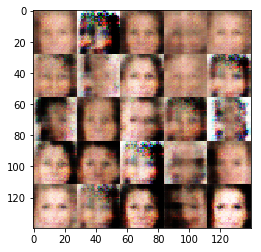

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.7514... Generator Loss: 2.0460
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 1.5959
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.9162


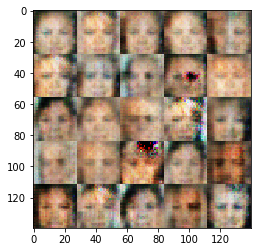

Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 1.9071... Generator Loss: 1.8515


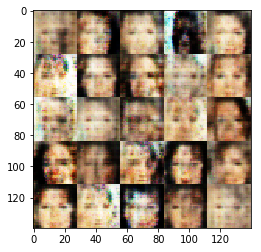

Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 2.5004... Generator Loss: 0.1438
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 1.5935


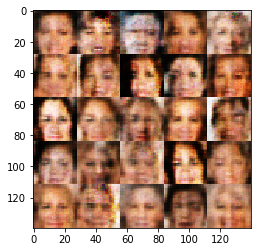

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8080


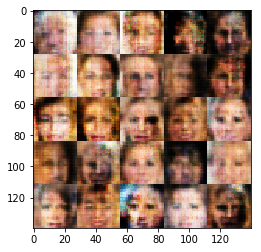

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6982


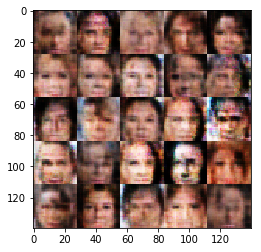

Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 0.2278... Generator Loss: 1.7729
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 3.1900
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6940


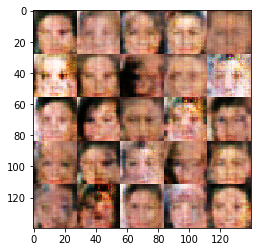

Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 2.2620
Epoch 1/1... Discriminator Loss: 3.5049... Generator Loss: 0.0651
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6377


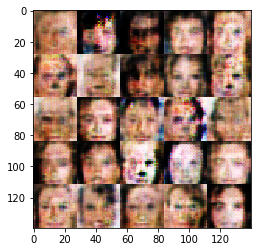

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6858


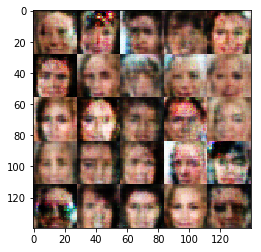

Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6015


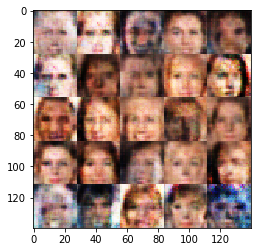

Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.5859


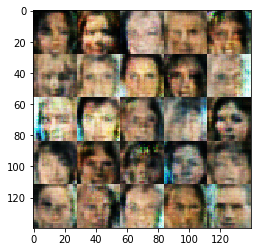

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 1.1158


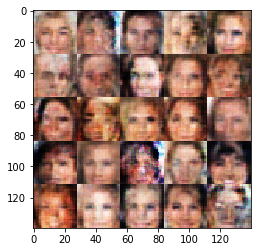

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7158


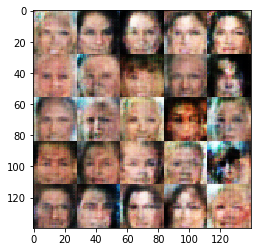

Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.4956


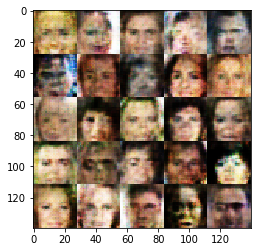

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.3112


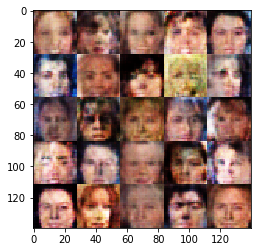

Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6094


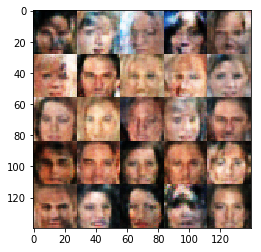

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8426


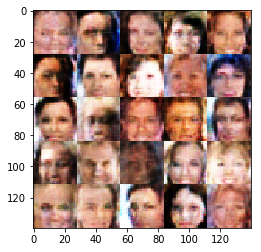

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5123


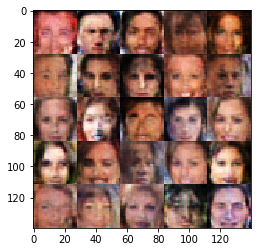

Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.5670


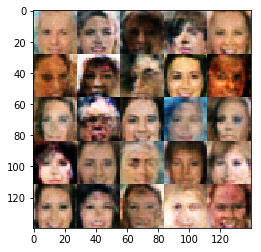

Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7288


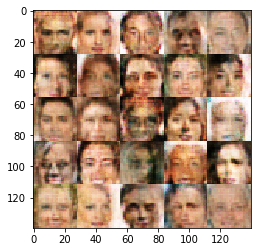

Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.5938


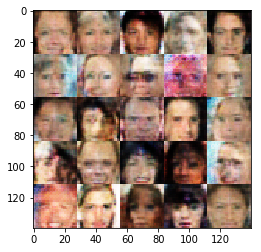

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.0658... Generator Loss: 3.1917
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 1.9499


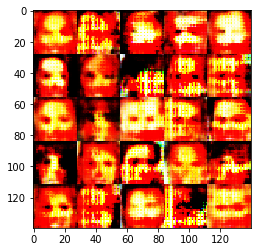

Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.9344... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6610


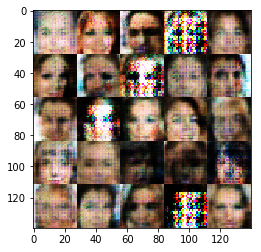

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6514


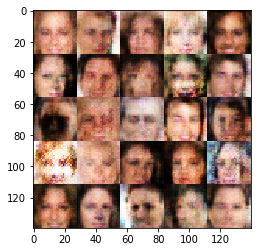

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6652


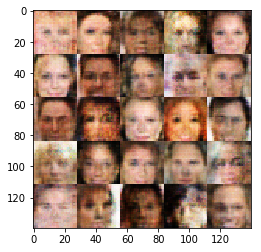

Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6744


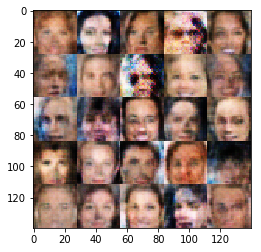

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6987


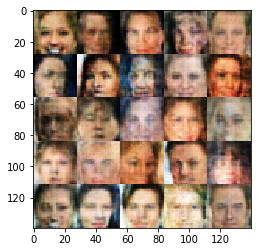

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7113


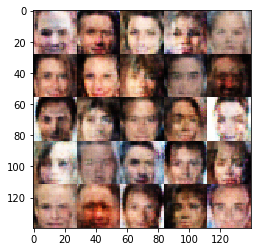

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7097


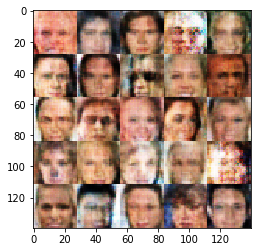

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6718


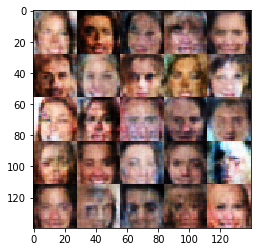

Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6955


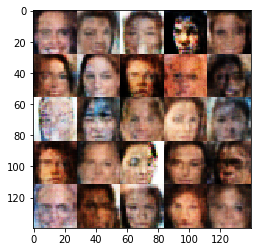

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6936


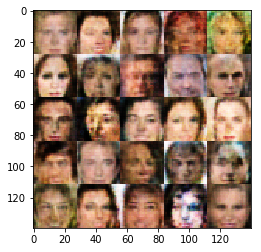

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6563


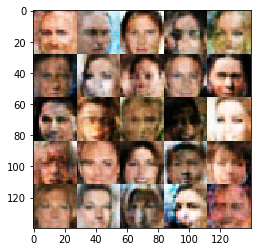

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7091


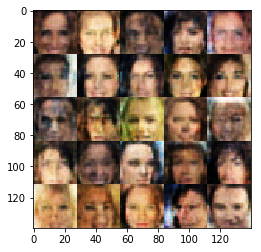

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6204


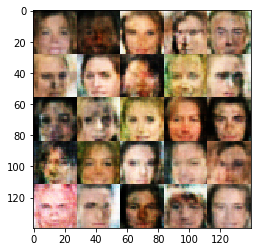

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6897


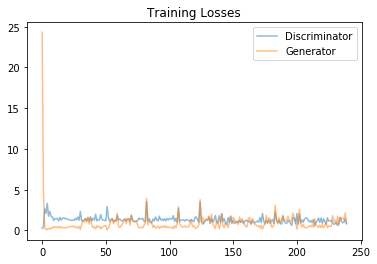

In [22]:
batch_size = 50
z_dim = 50
learning_rate = .01
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
        
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.